<a href="https://colab.research.google.com/github/w-decker/NMA_DL_Project/blob/main/NMA_DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMA DL Project

In [ ]:
# @title Mount Colab

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# @title Installations

# @markdown Some packages may need to be installed (e.g., `nilearn`). Type them in below and run the cell.

install = "nilearn" # @param{type: "string"}

!pip install {install} --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 27.1 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torch.utils.data import Dataset, DataLoader
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["font.family"] = "serif"
%matplotlib inline

import numpy as np
import numpy.typing as npt

from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr as corr

import nibabel as nib
from nilearn import plotting

import requests, os, tarfile

from tqdm.auto import tqdm

from PIL import Image

In [ ]:
# @title Helper functions

# @markdown `set_device()` -> Set device

# @markdown `download_kay()` -> Download dataset from Kay and Gallant

# @markdown `kay_exists()` -> Check that Kay and Gallant dataset exists

# @markdown `load_kay()` -> Load dataset from Kay and Gallant into workspace

# @markdown `random_image()` -> Choose random image from stimuli

# @markdown `model_layers()` -> Return model layer information

# @markdown `fit_pca()` -> Principle components analysis on image stimuli

# @markdown `extract_features()` -> Extract AlexNet image features

# @markdown `split()` -> Return train, validate, test indices.

# @markdown `extract_multiple_features()` -> Extract features from multiple layers

# @markdown `get_activations()` -> Get "raw" activations from model

# @markdown `rsa()` -> Compute RSA over fMRI data and model activations

# modified from NMA
def set_device(device:str=None) -> str:
  """Set device

  Paremeters
  ----------
  device: str
    "cuda" or "cpu"

  Return
  ------
  device: str
  """
  assert device == 'cuda' or 'cpu' or None

  if device is None:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
  else:
    device = device

  return device

# modified from NMA
def download_kay():
  """Download dataset from Kay and Gallant"""

  fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
  urls = ["https://osf.io/r638s/download",
      "https://osf.io/yqb3e/download",
      "https://osf.io/ymnjv/download"]

  for fname, url in zip(fnames, urls):
    if not os.path.isfile(fname):
      try:
        r = requests.get(url)
      except requests.ConnectionError:
        print("!!! Failed to download data !!!")
      else:
        if r.status_code != requests.codes.ok:
          print("!!! Failed to download data !!!")
        else:
          print(f"Downloading {fname}...")
          with open(fname, "wb") as fid:
            fid.write(r.content)
          print(f"Download {fname} completed!")

def kay_exists() -> bool:
  """Check that Kay and Gallant dataset exists"""

  fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]

  return all(map(os.path.exists, fnames))

# modified from NMA
def load_kay() -> dict | np.ndarray | np.ndarray:
  """Load dataset from Kay and Gallant into workspace"""

  with np.load( "kay_images.npz") as dobj:
    dat = dict(**dobj)
    labels = np.load('kay_labels.npy')
    val_labels = np.load('kay_labels_val.npy')

  return dat, labels, val_labels

def random_image(data:dict):
  """Choose random image from stimuli"""
  idx = np.random.choice(np.arange(0, len(data["stimuli"])), 1)
  print(idx)
  return idx, data["stimuli"][idx, :, :].squeeze(axis=0) # stimuli dimensions known a priori

def model_layers(model):
  """Return model layer information"""
  _, layers = get_graph_node_names(model)
  print('Hint: use `torchvision.models.feature_extraction.create_feature_extractor` to access layer feature maps.')
  return(layers)

# from algonauts 2023 tutorial
def fit_pca(feature_extractor, dataloader, batch_size):
  """Principle components analysis on image stimuli"""

  # Define PCA parameters
  pca = IncrementalPCA(n_components=100, batch_size=batch_size)

  # Fit PCA to batch
  for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
      # Extract features
      ft = feature_extractor(d)
      # Flatten the features
      ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
      # Fit PCA to batch
      pca.partial_fit(ft.detach().cpu().numpy())
  return pca

# from algonauts 2023 tutorial
def extract_features(feature_extractor, dataloader, pca):
  """Extract AlexNet image features"""
  features = []
  for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
      # Extract features
      ft = feature_extractor(d)
      # Flatten the features
      ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
      # Apply PCA transform
      ft = pca.transform(ft.cpu().detach().numpy())
      features.append(ft)
  return np.vstack(features)

def split(n:int, n_test:int, seed: int) -> int | int | int:
  """
  Return train, validate, test indices.
  90% go to train and validate

  Parameters
  ----------
  n: int
    Size of dataset

  n_test: int
    Size of test set

  seed: int

  Return
  ------
  train: int
  validate: int
  test: int
  """
  np.random.seed(seed)

  n_train = int(np.round(n / 100 * 90))
  idxs = np.arange(n)
  np.random.shuffle(idxs)
  train, val = idxs[:n_train], idxs[n_train:]
  test = np.arange(n_test)

  return train, val, test

def extract_multiple_features(model, stimuli, layer_idx):
  """Extract features from multiple layers"""
  features = []
  def hook_fn(module, input, output):
      features.append(output.cpu().data.numpy())

  handle = model.features[layer_idx].register_forward_hook(hook_fn)
  with torch.no_grad():
      _ = model(stimuli)
  handle.remove()

  return np.array(features).squeeze()

def get_activations(model, layer, dataloader):
  """Get "raw" activations from model"""
  activations = []
  def hook_fn(module, input, output):
      activations.append(output.detach().cpu().numpy())
  handle = layer.register_forward_hook(hook_fn)
  model.eval()
  with torch.no_grad():
      for batch in dataloader:
          model(batch)
  handle.remove()
  return np.concatenate(activations, axis=0)

def rsa(fmri_data, model_activations):
  """Compute RSA over fMRI data and model activations"""
  fmri_rdm = squareform(pdist(fmri_data, 'correlation'))
  model_rdm = squareform(pdist(model_activations, 'correlation'))
  correlation = np.corrcoef(fmri_rdm.flatten(), model_rdm.flatten())[0, 1]
  return correlation



In [ ]:
# @title Initialize some parameters
device = set_device()
print(f'Device: {device}')

batch_size = 500
print(f'Batch size: {batch_size}')

Device: cpu
Batch size: 500


In [ ]:
# @title Download and import data

# download the data
if not kay_exists():
  download_kay()
else:
  print('Data already exists.')

# import data
data, labels, val_labels = load_kay()
print(f'Data loaded as `data`, `labels`, and `val_labels`.')
print(f'`labels.shape`: {labels.shape}')
print(f'`val_labels.shape`: {val_labels.shape}')

Download kay_labels.npy completed!
Download kay_labels_val.npy completed!
Download kay_images.npz completed!
Data loaded as `data`, `labels`, and `val_labels`.
`labels.shape`: (4, 1750)
`val_labels.shape`: (4, 120)


# Plot brain data

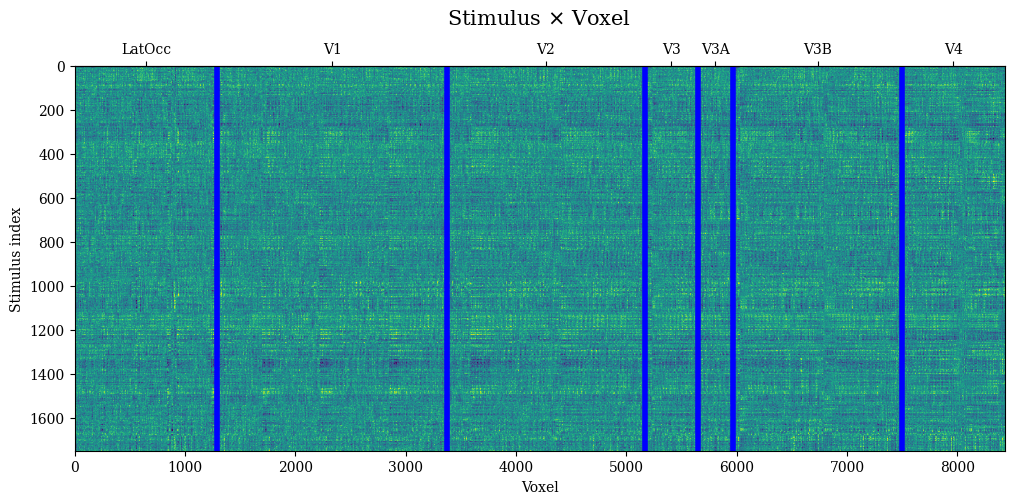

In [ ]:
##### customize here #####
cmap = 'viridis' # color map
linec = 'blue' # color of ROI borders
##########################

fig, ax = plt.subplots(figsize=(12, 5))
ax.imshow(data['responses'], vmin=-1, vmax=1, aspect='auto',
           cmap=cmap)
ax.set_title(r'Stimulus $\times$ Voxel', pad=30, fontsize=15)
ax.set_xlabel('Voxel')
ax.set_ylabel('Stimulus index')

roi_locs = np.bincount(data["roi"])[1:]
roi_names = ['LatOcc','V1','V2','V3','V3A','V3B','V4']

for roi in np.cumsum(roi_locs[:-1]):
  ax.axvline(roi, color=linec, linewidth=4)

secax = ax.secondary_xaxis('top')
tick_positions = np.cumsum(roi_locs) - roi_locs//2
secax.set_xticks(tick_positions)
secax.set_xticklabels(roi_names)

plt.show()

# Plot an example stimulus

[1049]


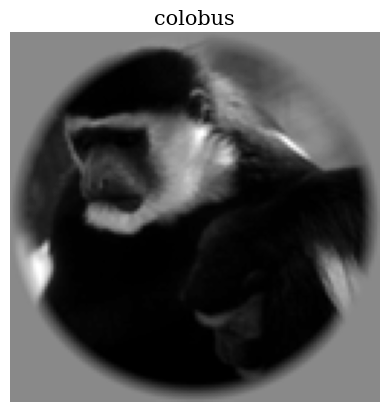

In [ ]:
label_idx, img = random_image(data)
plt.imshow(img, cmap="gray")
plt.title(labels[3, label_idx][0], fontsize=15)
plt.axis('off')
plt.show()

# Load [`AlexNet`](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

In [ ]:
model = alexnet(pretrained=True)
model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 89.0MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# @title Download, unzip and load finetuned `AlexNet`

!gdown 12uaLXLvWKdqUjr0C92dlKl_bBvt6TeVo
!unzip alexnet_finetuned_model.zip -d models/

finetuned_model = torch.load("models/alexnet_finetuned_model.pth")
finetuned_model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
finetuned_model.eval() # set the model to evaluation mode, since you are not training it

Downloading...
From (original): https://drive.google.com/uc?id=12uaLXLvWKdqUjr0C92dlKl_bBvt6TeVo
From (redirected): https://drive.google.com/uc?id=12uaLXLvWKdqUjr0C92dlKl_bBvt6TeVo&confirm=t&uuid=29f45204-cb82-4c67-b609-58f2cf795a81
To: /content/alexnet_finetuned_model.zip
100% 220M/220M [00:02<00:00, 86.9MB/s]
Archive:  alexnet_finetuned_model.zip
replace models/alexnet_finetuned_model.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: models/alexnet_finetuned_model.pth  


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Establish transformations

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])

# Create `Dataset` for images and corresponding labels

**Note:** Each image has a corresponding $4 \times 1$ array of labels, $L$. Rows are. different sets of labels ($4$ in length) generated by work conducted by the authors of the dataset. Here, one label is used ($L_{4, 4}$).

In [ ]:
class KayDataset(Dataset):
    def __init__(self, imgs, idxs, transform, device):
        self.imgs_paths = np.array(imgs)[idxs]
        self.transform = transform

        if not device:
          self.device = set_device()

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(self.device)
        return img

In [ ]:
# reshape
images = data["stimuli"][:, np.newaxis, :, :]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Convert to PIL and apply transformations
transformed_images = torch.stack([transform(Image.fromarray((image[0] * 255).astype(np.uint8))) for image in images])

# labels
labels2 = []
[labels2.append(labels[3, i]) for i in range(len(labels.T))]

# PyTorch cusom dataset
class KayDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

# Create dataset and dataloader
dataset = KayDataset(transformed_images, labels2)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Get train, validate and test indices

In [ ]:
train, val, test = split(n=len(data['stimuli']), n_test=len(data['stimuli_test']), seed=2024)

print(f'Training size: {len(train)}\n')
print(f'Validation size: {len(val)}\n')
print(f'Testing size: {len(test)}\n')

Training size: 1575

Validation size: 175

Testing size: 120



# Modify images another way

In [ ]:
#3-channel images by duplicating grayscale channel
stimuli = np.repeat(data['stimuli'][..., np.newaxis], 3, axis=-1)
stimuli_test = np.repeat(data['stimuli_test'][..., np.newaxis], 3, axis=-1)

stimuli_tensor = torch.tensor(stimuli, dtype=torch.float32).permute(0, 3, 1, 2)
stimuli_test_tensor = torch.tensor(stimuli_test, dtype=torch.float32).permute(0, 3, 1, 2)
responses_tensor = torch.tensor(data['responses'], dtype=torch.float32)
responses_test_tensor = torch.tensor(data['responses_test'], dtype=torch.float32)

# Extract features from multiple layers

In [ ]:
#features for all training stimuli from each layer
layer_idx = [2, 5, 8, 10]  #layer indices
train_features = {}
test_features = {}

pca = PCA(n_components=5)

for idx in tqdm(layer_idx):
  features = extract_multiple_features(model, stimuli_tensor, idx)
  features_flattened = features.reshape(features.shape[0], -1)
  train_features[idx] = pca.fit_transform(features_flattened)

  test_feats = extract_multiple_features(model, stimuli_test_tensor, idx)
  test_features_flattened = test_feats.reshape(test_feats.shape[0], -1)
  test_features[idx] = pca.transform(test_features_flattened)


  0%|          | 0/4 [00:00<?, ?it/s]

# Voxel-wise model

In [ ]:
voxel_layer_correlations = np.zeros((data['responses'].shape[1], len(layer_idx)))
best_models = {}

for idx, layer in tqdm(enumerate(layer_idx)):
    features_flattened = train_features[layer]
    model = MultiOutputRegressor(Ridge(alpha=1.0))
    model.fit(features_flattened, data['responses'])
    preds = model.predict(features_flattened)
    r2 = r2_score(data['responses'], preds, multioutput='raw_values')
    voxel_layer_correlations[:, idx] = r2
    best_models[layer] = model

#the most correlated layer for each voxel
most_correlated_layers = np.argmax(voxel_layer_correlations, axis=1)

0it [00:00, ?it/s]

In [ ]:
vals = np.unique(most_correlated_layers)

for roi, val in zip(np.cumsum(roi_locs[:-1]), vals):

  val_count = {}
  val_count[val] = (np.count_nonzero(data['responses'][] == val))

val_count


{3: 0}

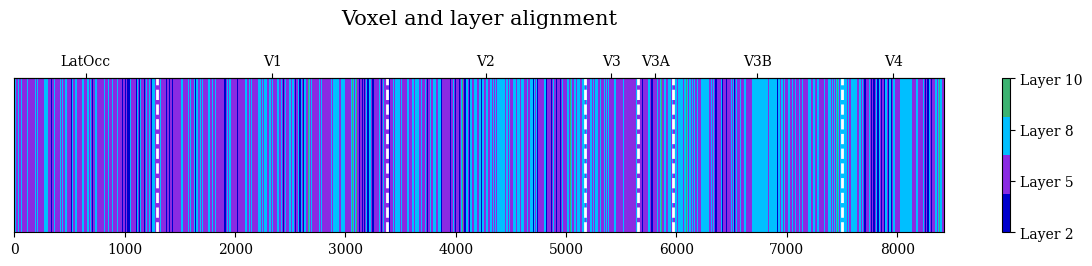

In [ ]:
##### customize here #####
colors_ = ["mediumblue", "blueviolet", "deepskyblue", "mediumseagreen"]
linec = 'white'
linestyle = '--'
##########################

plt.figure(figsize=(15, 2))
list_cmap = ListedColormap(colors_)
plt.imshow(most_correlated_layers.reshape((most_correlated_layers.shape[0], 1)).T, aspect='auto',cmap=list_cmap)
plt.gca().get_yaxis().set_visible(False)
cbar = plt.colorbar(ticks=[0, 1, 2, 3])  # Set discrete ticks
cbar.set_ticklabels(['Layer 2', 'Layer 5', 'Layer 8', 'Layer 10'])  # Set custom labels


roi_locs = np.bincount(data["roi"])[1:]
roi_names = ['LatOcc','V1','V2','V3','V3A','V3B','V4']

for roi in np.cumsum(roi_locs[:-1]):
  plt.axvline(roi, color=linec, linewidth=2, linestyle=linestyle)

secax = plt.gca().secondary_xaxis('top')
tick_positions = np.cumsum(roi_locs) - roi_locs//2
secax.set_xticks(tick_positions)
secax.set_xticklabels(roi_names)

plt.title('Voxel and layer alignment\n', fontsize=15)

plt.show()

In [ ]:
np.unique(most_correlated_layers[0:1294])

array([0, 1, 2, 3])

# Representational similarity analysis